# Exploring Seeing Double FFNN Dynamics

#### Overall Idea: Track the evolution of certain attractors with respect to changes in $\rho$. It's then possible to assemble a bifurcation picture of the RCs dynamics as $\rho$ changes.

### Initialize: Import Libraries, Specify Parameters, Import Fly Model, Create Reservoir

In [1]:
# imports
import numpy as np
import numpy.linalg as npl
from numpy.linalg import inv
from numpy import random
import scipy as scipy
import scipy.sparse as sparse
from scipy.sparse import diags
from scipy.sparse.linalg import eigs
from scipy.linalg import sqrtm
from scipy.sparse import identity
from scipy.sparse import vstack
from multiprocessing import Pool
from functools import partial
from MAIN_22 import generate_M,generate_Win,Big_listen_stage,Big_train_stage,predict_stage,generate_NetOut
from MAIN_22 import Generate_predicitons,Generate_MF_predicitons,Generate_training_data,BlendingTechnique
from LCsys_11 import LCsys
from Circle_error_tools import Error_analysis_of_Pred_Circle,test_Error_analysis_of_Pred_Circle
from Circle_error_tools import check_errmaxminCA,check_errmaxminCB, fix_length_of_maxmins_with_nans
from Circle_error_tools import estimate_circ_center,direction_of_rotation_stricter,roundness
from Circle_error_tools import list_to_check_if_LC
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from matplotlib import cm
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
rc('text', usetex=True)
from PlotTools import make_hist, make_hist_ev
from IPython.core.debugger import set_trace

# time constants for integration
dt = 0.01 #time step
Tlisten = 37.7 #Listening Time 6T
ListenEndTime = int(Tlisten/dt) #Discretised Listen Time
Ttrain = 94.25 + Tlisten #Training Time 15T
TrainEndTime = int(Ttrain/dt) #Discretised Train Time
Tpredict = 169.65 + Ttrain #Predicting Time 27T
PredictEndTime = int(Tpredict/dt) #Discretised Predict Time
t_time = np.linspace(0.0,Tpredict,int(Tpredict/dt)) #(Total Time)
SysDim = 2 #Used in initialising Win and regression

# res params
gama = 5 # damping coefficient
sigma = 0.2 # input strength
beta = 1e-2 #Regularization Parameter
alpha = 0.5 #Blending parameter

# input data params
dd1=5
dd2=-5
omega1=1
omega2=-1

# error bounds
predtime=PredictEndTime-TrainEndTime
FP_err_lim=1e-3
sample_start=predtime-5000#+10000
sample_end=predtime-1000#+10000
stepback=20
randrange=10
pts1=250
pts2=200
pts3=150
pts4=100
FP_sample_start=predtime-1000#+10000
FP_sample_end=predtime#+10000
iter_no=1000
LC_err_tol=0.01
LC_err_tol_v3=0.00001
rounding_no=2

# import fly model
with open(f'../models/LHRdiag_wtol50.npy', 'rb') as f:
    ffnn = np.load(f)

# params to investigate
N = ffnn.shape[0]  # no. of nodes - shape[0] is 426
rho=1.4 #default value
d = 0.05 #prob. of an element of M to be nonzero 
SysDim=2

# create reservoir
# first time...
# Minit = sparse.csr_matrix(np.copy(M))
# largest_evalue = np.abs(sparse.linalg.eigs(Minit, k=1, which='LM', return_eigenvectors=False))
# M = sparse.csr_matrix((rho / abs(largest_evalue[0])) * Minit)
# Win = generate_Win(N,SysDim)
# np.savetxt("MinitFFNN.txt",Minit.toarray())
# np.savetxt("WinFFNN.txt",Win.toarray())

# after first time...
Minit = np.genfromtxt("MinitFFNN.txt",unpack=True)
Minit = Minit.T
largest_evalue = sparse.linalg.eigs(Minit,k=1,which='LM',return_eigenvectors=False)
Win = np.genfromtxt("WinFFNN.txt", unpack=True)
Win = sparse.csr_matrix(Win.T)

In [2]:
def trainRC_part1(rhospace,Minit,xcen,alpha,dt,t_time,ListenEndTime,TrainEndTime,PredictEndTime,Win,largest_evalue,N,dd1,
                  omega1,dd2,omega2,gama,sigma,beta,FP_err_lim,FP_sample_start,FP_sample_end,LC_err_tol,rounding_no,
                  sample_start,sample_end,stepback,Xcen1,ycen,iter_no,Xcen2):
    print('rho','__','N','__','err_C1','__','err_C2','__','C1 rel rnd','__','C2 rel rnd','__','C1filt','__','C2filt')
    for rho in rhospace:
        M = (rho/abs(largest_evalue[0]))*Minit
        M = sparse.csr_matrix(M)     
        ##Multifunctional case
        Xpredict_1_MF,Xpredict_2_MF,Rpredictsq_1_MF,Rpredictsq_2_MF, xy_1, xy_2, r_1, r_2, Wout_alpha, NetOut_1_MF,NetOut_2_MF=Generate_MF_predicitons(rho,xcen,alpha,dt,t_time,ListenEndTime,TrainEndTime,PredictEndTime,M,Win,largest_evalue,N,dd1,omega1,dd2,omega2,gama,sigma,beta)
        xp1_C1,xp2_C1 = Xpredict_1_MF#Actual output
        xpredict1_C1_MF,xpredict2_C1_MF = NetOut_1_MF#RC prediction
        xp1_C2,xp2_C2 = Xpredict_2_MF#Actual output
        xpredict1_C2_MF,xpredict2_C2_MF = NetOut_2_MF#RC prediction
        ##Error Analysis
        #C1
        err_C1,C1_vel_dir_strict,C1_roundness,C1_Rad_perr,C1_xcenter_err,C1_ycenter_err,x_C1_no_of_unique_maxima,C1_periodic_prof,xmax_localmaxima_C1,xmin_localmaxima_C1,xmax_localminima_C1,xmin_localminima_C1,ymax_localmaxima_C1,ymin_localmaxima_C1,ymax_localminima_C1,ymin_localminima_C1=test_Error_analysis_of_Pred_Circle(xpredict1_C1_MF,xpredict2_C1_MF,FP_err_lim,FP_sample_start,FP_sample_end,LC_err_tol,rounding_no,sample_start,sample_end,stepback,dd1,Xcen1,ycen,iter_no)
        C1rel_roundness=C1_roundness/dd1
        err_C1filt=check_errmaxminCA(err_C1,Xcen1,xmax_localmaxima_C1,ymax_localmaxima_C1,xmax_localminima_C1,ymax_localminima_C1,xmin_localmaxima_C1,ymin_localmaxima_C1,xmin_localminima_C1,ymin_localminima_C1)
        #C2
        err_C2,C2_vel_dir_strict,C2_roundness,C2_Rad_perr,C2_xcenter_err,C2_ycenter_err,x_C2_no_of_unique_maxima,C2_periodic_prof,xmax_localmaxima_C2,xmin_localmaxima_C2,xmax_localminima_C2,xmin_localminima_C2,ymax_localmaxima_C2,ymin_localmaxima_C2,ymax_localminima_C2,ymin_localminima_C2=test_Error_analysis_of_Pred_Circle(xpredict1_C2_MF,xpredict2_C2_MF,FP_err_lim,FP_sample_start,FP_sample_end,LC_err_tol,rounding_no,sample_start,sample_end,stepback,dd1,Xcen2,ycen,iter_no)
        C2rel_roundness=C2_roundness/dd1
        err_C2filt=check_errmaxminCB(err_C2,Xcen2,xmax_localmaxima_C2,ymax_localmaxima_C2,xmax_localminima_C2,ymax_localminima_C2,xmin_localmaxima_C2,ymin_localmaxima_C2,xmin_localminima_C2,ymin_localminima_C2)
        print([rho,N,err_C1,err_C2,C1rel_roundness,C2rel_roundness,err_C1filt,err_C2filt])
        return xpredict1_C1_MF,xpredict2_C1_MF,xpredict1_C2_MF,xpredict2_C2_MF,xy_1,Wout_alpha,M
        
def plotpreds(x1C1,x2C1,x1C2,x2C2):
    plt.plot(x1C1,x2C1, label='Circle 1 Predict')
    plt.plot(x1C1[-1],x2C1[-1],'C0.')
    plt.plot(x1C2,x2C2, label = 'Circle 2 Predict')
    plt.plot(x1C2[-1],x2C2[-1],'C1.')
    plt.legend()
    print(x1C1[-1],x2C1[-1])
    print(x1C2[-1],x2C2[-1])
    plt.show

def plotthree(xpred1_from_rand_IC,xpred2_from_rand_IC):
    plt.figure(figsize=(16,6))
    plt.subplot(1,3,1)#time trace of predicted x variable
    plt.plot(xpred1_from_rand_IC)
    plt.title('Time Trace of Pred. X Var.')
    plt.subplot(1,3,2)#dynamics in projected state space
    plt.plot(xpred1_from_rand_IC,xpred2_from_rand_IC)
    plt.title('Dynamics -- x1 vs x2 space')
    plt.subplot(1,3,3)#dynamics in projected state space with transient cutoff
    plt.plot(xpred1_from_rand_IC[-6000:],xpred2_from_rand_IC[-6000:])
    plt.plot(xpred1_from_rand_IC[-10],xpred2_from_rand_IC[-10],'ro')
    plt.plot(xpred1_from_rand_IC[-1:],xpred2_from_rand_IC[-1:],'go')
    plt.title('Is there a settled FP? Check.')
    print(f'({xpred1_from_rand_IC[-1:][0]},{xpred2_from_rand_IC[-1:][0]})')
    plt.show()
    
def inspect_from_random_IC(random_vector,xy_1,Wout_alpha,TrainEndTime,PredictEndTime,t_time,
                           dt,dd1,omega1,Xcen1,gama,sigma,M,Win):
    Xpred_rand, Rpredsq_rand = predict_stage(xy_1,random_vector,Wout_alpha,TrainEndTime,
                                             PredictEndTime,t_time,dt,dd1,omega1,Xcen1,
                                             gama,sigma,M,Win)
    NetOut_Rand = generate_NetOut(Wout_alpha,Rpredsq_rand)
    xpred1_rand_lr0,xpred2_rand_lr0=NetOut_Rand
    plotthree(xpred1_rand_lr0, xpred2_rand_lr0)

def inspect_from_random_IC_for_multiple_rho(rand_vec_leading_to_fp,rhospace,Minit,xcen,dt,t_time,
                                            ListenEndTime,TrainEndTime,Win,N,dd1,omega1,dd2,omega2,
                                            gama,sigma,alpha,beta,xy_1,PredictEndTime,Xcen1,
                                            FP_err_lim,Rprof,FP_arr):
    i=0 # i.e. we want to use the fixed point as our guide... let's use the rand vec leading to FP1
    for rho in rhospace:
        M = (rho/abs(largest_evalue[0]))*Minit
        M = sparse.csr_matrix(M)

        Xtrain_1,Rtrain_1,Rtrainsq_1,Xtrain_2,Rtrain_2,Rtrainsq_2=Generate_training_data(rho,xcen,
                                                            dt,t_time,ListenEndTime,
                                                            TrainEndTime,M,Win,N,dd1,omega1,
                                                            dd2,omega2,gama,sigma)
        Wout_alpha=BlendingTechnique(alpha,Xtrain_1,Xtrain_2,Rtrainsq_1,Rtrainsq_2,beta)
        RunPts=10000
        EndTime=TrainEndTime+RunPts
        count1 = 0
        while count1 == 0:
            if i==0:
                #The R_IC is set as the random IC that lead to finding the FP mentioned above, 
                R_IC = rand_vec_leading_to_fp # 2*np.random.random(N) - 1 #(as option to start tracking from different random IC)
            else:
                R_IC = Rprof[i-1]
            
            Xpredict_C1_rand, Rpredictsq_rand = predict_stage(xy_1,R_IC,Wout_alpha,
                                                              TrainEndTime,PredictEndTime,t_time,dt,
                                                              dd1,omega1,Xcen1,gama,sigma,M,Win)
            NetOut_Rand = generate_NetOut(Wout_alpha,Rpredictsq_rand)
            xp1_C1,xp2_C1 = Xpredict_C1_rand#Actual output
            xpredict1_rand,xpredict2_rand = NetOut_Rand#MF Matrix prediction

            if all(i < FP_err_lim for i in abs(np.diff(xpredict2_rand[RunPts-1000:RunPts:50]))) == True and xpredict1_rand[-1] > -100 and xpredict2_rand[-1] > -100:
                rsave1 = [rho,Xcen1,xpredict1_rand[-1],xpredict2_rand[-1],Rpredictsq_rand.T[-1][0:1000]]
                print(f'rho={rho}, Xcen={Xcen1}, FP: ({xpredict1_rand[-1]},{xpredict2_rand[-1]})') #print out FP location
                count1 += 1
                FP_arr[i]=[rho,Xcen1,xpredict1_rand[-1],xpredict2_rand[-1]] # here we put the information
                Rprof[i]=Rpredictsq_rand.T[-1][0:N] # here we save the random starting point leading to the FP
                i+=1
            else:
                print(f'Bifurcation possible: {rho},{Xcen1},{4.0}') #,NetOut_Rand.T[-2:-1,2])
                return xpredict1_rand, xpredict2_rand, rho, FP_arr, Rprof
    print("done...")
    return xpredict1_rand, xpredict2_rand, rho, FP_arr, Rprof

def inspect_from_random_IC_for_multiple_rho_KEEP_GOING(rand_vec_leading_to_fp,rhospace,Minit,xcen,dt,t_time,
                                            ListenEndTime,TrainEndTime,Win,N,dd1,omega1,dd2,omega2,
                                            gama,sigma,alpha,beta,xy_1,PredictEndTime,Xcen1,
                                            FP_err_lim,Rprof,FP_arr):
    i=0 # i.e. we want to use the fixed point as our guide... let's use the rand vec leading to FP1
    for rho in rhospace:
        M = (rho/abs(largest_evalue[0]))*Minit
        M = sparse.csr_matrix(M)

        Xtrain_1,Rtrain_1,Rtrainsq_1,Xtrain_2,Rtrain_2,Rtrainsq_2=Generate_training_data(rho,xcen,
                                                            dt,t_time,ListenEndTime,
                                                            TrainEndTime,M,Win,N,dd1,omega1,
                                                            dd2,omega2,gama,sigma)
        Wout_alpha=BlendingTechnique(alpha,Xtrain_1,Xtrain_2,Rtrainsq_1,Rtrainsq_2,beta)
        RunPts=10000
        EndTime=TrainEndTime+RunPts
        count1 = 0
        while count1 == 0:
            if i==0:
                #The R_IC is set as the random IC that lead to finding the FP mentioned above, 
                R_IC = rand_vec_leading_to_fp # 2*np.random.random(N) - 1 #(as option to start tracking from different random IC)
            else:
                R_IC = Rprof[i-1]
            
            Xpredict_C1_rand, Rpredictsq_rand = predict_stage(xy_1,R_IC,Wout_alpha,
                                                              TrainEndTime,PredictEndTime,t_time,dt,
                                                              dd1,omega1,Xcen1,gama,sigma,M,Win)
            NetOut_Rand = generate_NetOut(Wout_alpha,Rpredictsq_rand)
            xp1_C1,xp2_C1 = Xpredict_C1_rand#Actual output
            xpredict1_rand,xpredict2_rand = NetOut_Rand#MF Matrix prediction

            if all(i < FP_err_lim for i in abs(np.diff(xpredict2_rand[RunPts-1000:RunPts:50]))) == True and xpredict1_rand[-1] > -100 and xpredict2_rand[-1] > -100:
                rsave1 = [rho,Xcen1,xpredict1_rand[-1],xpredict2_rand[-1],Rpredictsq_rand.T[-1][0:1000]]
                print(f'rho={rho}, Xcen={Xcen1}, FP: ({xpredict1_rand[-1]},{xpredict2_rand[-1]})') #print out FP location
                count1 += 1
                FP_arr[i]=[rho,Xcen1,xpredict1_rand[-1],xpredict2_rand[-1]] # here we put the information
                Rprof[i]=Rpredictsq_rand.T[-1][0:N] # here we save the random starting point leading to the FP
                i+=1
            else:
                print(f'Bifurcation possible: {rho},{Xcen1},{4.0}') #,NetOut_Rand.T[-2:-1,2])
                rsave1 = [rho,Xcen1,xpredict1_rand[-1],xpredict2_rand[-1],Rpredictsq_rand.T[-1][0:1000]]
                print(f'rho={rho}, Xcen={Xcen1}, FP: ({xpredict1_rand[-1]},{xpredict2_rand[-1]})') #print out FP location
                count1 += 1
                FP_arr[i]=[rho,Xcen1,xpredict1_rand[-1],xpredict2_rand[-1]] # here we put the information
                Rprof[i]=Rpredictsq_rand.T[-1][0:N] # here we save the random starting point leading to the FP
                i+=1
                #return xpredict1_rand, xpredict2_rand, rho, FP_arr, Rprof
    print("done...")
    return xpredict1_rand, xpredict2_rand, rho, FP_arr, Rprof

def limitcycletracking(rand_vec_leading_to_fp,RprofLC,LC_arr,ErrCs,
                       xy_1,Minit,xcen,dt,t_time,ListenEndTime,TrainEndTime,Win,N,dd1,omega1,dd2,omega2,gama,sigma,
                       alpha,beta,PredictEndTime,Xcen1,sample_start,sample_end,stepback,FP_err_lim,FP_sample_start,
                       FP_sample_end,LC_err_tol):
    circle = ''
    i=0
    for rho in rhospace:
        M = (rho/abs(largest_evalue[0]))*Minit
        M = sparse.csr_matrix(M)
        
        Xtrain_1,Rtrain_1,Rtrainsq_1,Xtrain_2,Rtrain_2,Rtrainsq_2=Generate_training_data(rho,xcen,dt,t_time,
                                                                                         ListenEndTime,TrainEndTime,
                                                                                         M,Win,N,dd1,omega1,
                                                                                         dd2,omega2,gama,sigma)
        Wout_alpha=BlendingTechnique(alpha,Xtrain_1,Xtrain_2,Rtrainsq_1,Rtrainsq_2,beta)
        RunPts=10000
        EndTime=TrainEndTime+RunPts
        count1 = 0
        while count1 == 0:
            if i==0:
                #The R_IC is set as the random IC that lead to finding the FP mentioned above, 
                R_IC = rand_vec_leading_to_fp # 2*np.random.random(N) - 1 #(as a option to start tracking from different random IC)
            else:
                R_IC = RprofLC[i-1]
            Xpredict_C1_rand, Rpredictsq_rand = predict_stage(xy_1,R_IC,Wout_alpha,
                                                              TrainEndTime,PredictEndTime,t_time,dt,
                                                              dd1,omega1,Xcen1,gama,sigma,M,Win)
            NetOut_Rand = generate_NetOut(Wout_alpha,Rpredictsq_rand)
            xp1_C1,xp2_C1 = Xpredict_C1_rand#Actual output
            xpredict1_rand,xpredict2_rand = NetOut_Rand#MF Matrix prediction
            
            if np.max(xpredict1_rand) < 150:#
                C_center_est,Cx_alpha_localmax_pos,Cy_alpha_localmax_pos,Cx_alpha_localmin_pos,Cy_alpha_localmin_pos=estimate_circ_center(xpredict1_rand,xpredict2_rand,sample_start,sample_end)
                C_xcenter_err=abs(Xcen1-C_center_est[0])#/C1_center_true[0]
                C_ycenter_err=abs(0-C_center_est[1])#/C1_center_true[1]
                C_vel_dir_strict,C_vel_x1max_strict,C_vel_x2max_strict,C_vel_x1min_strict,C_vel_x2min_strict=direction_of_rotation_stricter(xpredict1_rand,xpredict2_rand,Cx_alpha_localmax_pos,Cy_alpha_localmax_pos,Cx_alpha_localmin_pos,Cy_alpha_localmin_pos,stepback)
                C_roundness=roundness(xpredict1_rand,xpredict2_rand,Cx_alpha_localmax_pos,C_center_est[0],0)
                Cklist,Ckdifflist=list_to_check_if_LC(xpredict2_rand,sample_start,sample_end,FP_err_lim,FP_sample_start,FP_sample_end,LC_err_tol)

                if all(i < FP_err_lim for i in abs(np.diff(xpredict2_rand[RunPts-1000:RunPts:50]))) == True:
                    #print(rho,Xcen1,'FP',404.0)
                    err_C = 444.0
                    circle = 'Fixed Point'
                elif len(Ckdifflist) >= 2 and all(j == Ckdifflist[0] for j in Ckdifflist) == True and abs(Ckdifflist[0]) > 1e-16 and C_vel_dir_strict==1:
                    # ADJUSTMENT FROM MARCH 31st...
                    if((C_roundness/5) < 0.25):
                        err_C = 2.0#CA
                        circle = 'Circle A (clean)'
                    else:
                        err_C = 2.5
                        circle = 'Circle A (dirn only)'
                elif len(Ckdifflist) >= 2 and all(j == Ckdifflist[0] for j in Ckdifflist) == True and abs(Ckdifflist[0]) > 1e-16 and C_vel_dir_strict==-1:
                    # ADJUSTMENT FROM MARCH 31st...
                    if((C_roundness/5) < 0.25):
                        err_C = 5.0#CB
                        circle = 'Circle B (clean)'
                    else:
                        err_C = 5.5
                        circle = 'Circle B (dirn only)'
                elif len(Ckdifflist) >= 2 and all(j == Ckdifflist[0] for j in Ckdifflist) == True and abs(Ckdifflist[0]) > 1e-16 and C_vel_dir_strict==0:
                    err_C = 6.0#Cs
                    circle = 'Switch CIRCLE dynamics'
                elif C_vel_dir_strict==1:
                    err_C = 7.0#CA'
                    circle = 'Circle A, kind of chaotic'
                elif C_vel_dir_strict==-1:
                    err_C = 8.0#CB'
                    circle = 'Circle B, kind of chaotic'
                elif C_vel_dir_strict==0:
                    err_C = 9.0#S
                    circle = 'Switch CIRCLE dynamics on chaotic reconstruction'
                else:
                    err_C = 4.0#S
                    circle = 'Switch Dynamics'
                print(f'{circle} -- {[rho,Xcen1,err_C,np.max(xpredict1_rand),xpredict2_rand[np.argmax(xpredict1_rand)]]}')
                count1 += 1
                ErrCs[i] = err_C
                LC_arr[i]=[rho,Xcen1,np.max(xpredict1_rand),xpredict2_rand[np.argmax(xpredict1_rand)],np.min(xpredict1_rand),xpredict2_rand[np.argmin(xpredict1_rand)]]
                RprofLC[i]=Rpredictsq_rand.T[-1][0:N]
                i+=1
    return xpredict1_rand, xpredict2_rand, RprofLC, LC_arr, ErrCs

def savedata(filename, data):
    with open(f'ExploreSeeingDouble-Saved_Data/{filename}.npy', 'wb') as f:
        np.save(f, data)

def loaddata(filename):
    with open(f'ExploreSeeingDouble-Saved_Data/{filename}.npy', 'rb') as f:
        return np.load(f)
    
def display_results(Fparr, ErrCs):
    mylist = []
    newarr = np.hstack((ErrCs,Fparr))
    for i in range(newarr.shape[0]):
        if(newarr[i,0])==444:
            mylist.append("FP")
        elif(newarr[i,0])==2:
            mylist.append("CA_clean")
        elif(newarr[i,0])==2.5:
            mylist.append("CA_dirn")
        elif(newarr[i,0])==5:
            mylist.append("CB_clean")
        elif(newarr[i,0])==5.5:
            mylist.append("CB_dirn")
        elif(newarr[i,0])==6:
            mylist.append("Switch")
        elif(newarr[i,0])==7:
            mylist.append("CA_chaotic")
        elif(newarr[i,0])==8:
            mylist.append("CA_chaotic")
        elif(newarr[i,0])==9:
            mylist.append("Switch_chaos1")
        elif(newarr[i,0])==4:
            mylist.append("Switch_chaos2")
    newarr2 = np.asarray(mylist)
    newarr2 = newarr2.reshape(-1,1)
    newarr3 = np.hstack((newarr2,newarr))
    np.set_printoptions(threshold=1000) #default 1000
    import pandas as pd
    # Set the display options to show all rows and columns
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
#     # Reset the display options to their default values
#     pd.reset_option('display.max_rows')
#     pd.reset_option('display.max_columns')
    df3 = pd.DataFrame(newarr3)
    display(df3)
    #return newarr3

### Exploratory MF Params

In [3]:
# Main param to investigate...
#--------------------------------------------------------------------------------
rho_max=0.68
#--------------------------------------------------------------------------------
xcen=0.0
Xcen1=xcen
Xcen2=-Xcen1
ycen=0.0
rho_min=rho_max
rho_steps=1
rhospace=np.linspace(rho_min,rho_max,rho_steps)

### Train RC, Predict

rho __ N __ err_C1 __ err_C2 __ C1 rel rnd __ C2 rel rnd __ C1filt __ C2filt
[0.68, 426, 3.0, 3.0, 199.8, 199.8, 4.0, 4.0]
8.011575386349948 11.948578598637766
-9.629009275643593 9.987022425558692


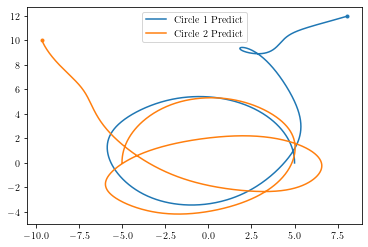

In [4]:
xpredict1_C1_MF,xpredict2_C1_MF,xpredict1_C2_MF,xpredict2_C2_MF,xy_1,Wout_alpha,M = trainRC_part1(rhospace,Minit,xcen,alpha,dt,
              t_time,ListenEndTime,TrainEndTime,PredictEndTime,Win,largest_evalue,N,dd1,omega1,dd2,omega2,gama,sigma,beta,
              FP_err_lim,FP_sample_start,FP_sample_end,LC_err_tol,rounding_no,sample_start,sample_end,stepback,Xcen1,ycen,
              iter_no,Xcen2)
plotpreds(xpredict1_C1_MF,xpredict2_C1_MF,xpredict1_C2_MF,xpredict2_C2_MF)

### Inspect dynamics from random ICs

## FP1: (8.011575401192196,11.948578596471526)

first random IC (start): [-0.59785809 -0.88837427  0.7850143   0.37161161 -0.18561483 -0.49452904
  0.36802181  0.98474845 -0.55574979 -0.8153057 ]
(8.011575386349948,11.948578598637765)


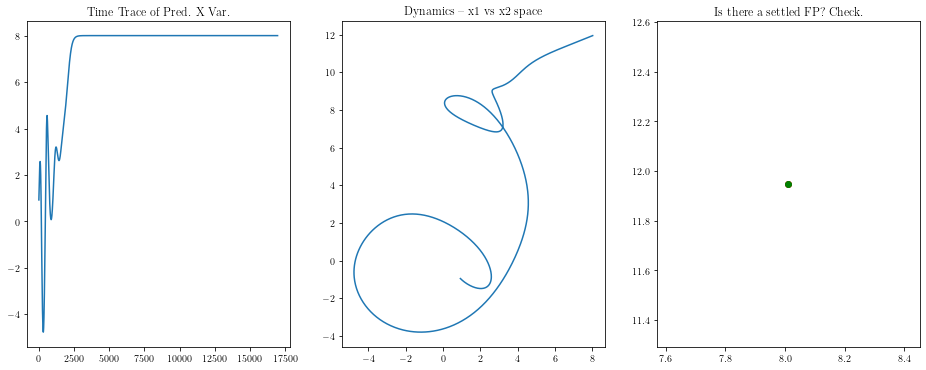

In [5]:
#rand_vec1 = 2*np.random.random(N) - 1 #random initial condition size N = (426,)
#savedata('rand_vec1',rand_vec1)
rand_vec1 = loaddata('rand_vec1')
print(f'first random IC (start): {rand_vec1[0:10]}')
inspect_from_random_IC(rand_vec1,xy_1,Wout_alpha,TrainEndTime,PredictEndTime,t_time,
                           dt,dd1,omega1,Xcen1,gama,sigma,M,Win)

## FP2: (9.62898186175914,-9.986863823744724)

third random IC (start): [ 0.80980211  0.32212358  0.53866487 -0.87656175 -0.69905408  0.33582725
 -0.13924971 -0.99303021  0.63344985 -0.30194417]
(9.62898183677305,-9.986863778470294)


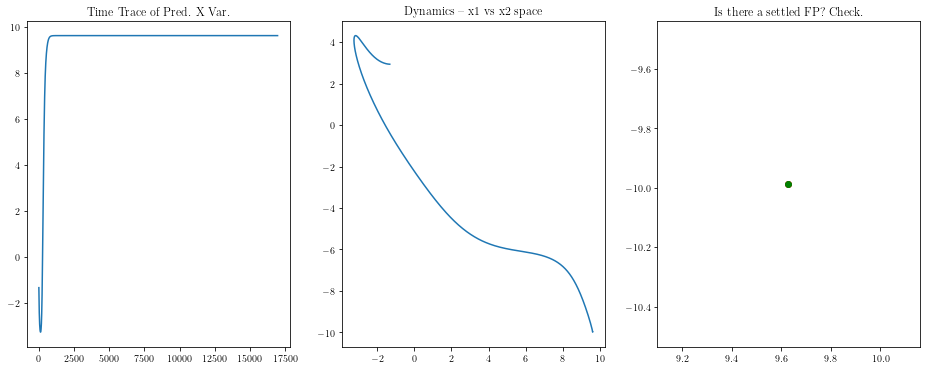

In [6]:
rand_vec3 = loaddata('rand_vec3')
print(f'third random IC (start): {rand_vec3[0:10]}')
inspect_from_random_IC(rand_vec3,xy_1,Wout_alpha,TrainEndTime,PredictEndTime,t_time,
                           dt,dd1,omega1,Xcen1,gama,sigma,M,Win)

### How does FP1 evolve wrt $\rho$? BROADLY...

In [7]:
# rho_max=2.5
# rho_min=0.2
# rho_steps=1500
# rhospace=np.linspace(rho_min,rho_max,rho_steps)
# R1_0=np.empty([rho_steps,N]) #random starting pts
# FP1_0=np.empty([rho_steps,6]) #fp1 evolution
# ErrCs1_0 = np.empty([rho_steps,1]) #err codes

In [8]:
# xpr1_0, xpr2_0,R1_0,FP1_0,ErrCs1_0 = limitcycletracking(-rand_vec1,R1_0,FP1_0,
#                        ErrCs1_0,
#                        xy_1,Minit,xcen,dt,t_time,ListenEndTime,TrainEndTime,
#                        Win,N,dd1,omega1,dd2,omega2,gama,sigma,alpha,beta,
#                        PredictEndTime,Xcen1,sample_start,sample_end,stepback,
#                        FP_err_lim,FP_sample_start,FP_sample_end,LC_err_tol)

In [9]:
# savedata('AprilFP1_0_1500',FP1_0)
# savedata('AprilErrCs1_0_1500',ErrCs1_0)

# display_results(FP1_0, ErrCs1_0)

In [10]:
FP1_0 = loaddata('AprilFP1_0_1500')
ErrCs1_0 = loaddata('AprilErrCs1_0_1500')

display_results(FP1_0, ErrCs1_0)

0      1                    2    3                   4  \
0                FP  444.0                  0.2  0.0    37.6284272233619   
1                FP  444.0  0.20153435623749166  0.0   37.45944514837876   
2                FP  444.0  0.20306871247498334  0.0   37.23769629991324   
3                FP  444.0    0.204603068712475  0.0  37.017672476476676   
4                FP  444.0  0.20613742494996665  0.0   36.79935998696109   
5                FP  444.0  0.20767178118745833  0.0   36.58274444181193   
6                FP  444.0  0.20920613742494998  0.0   36.36781084195107   
7                FP  444.0  0.21074049366244163  0.0    36.1545437254386   
8                FP  444.0   0.2122748498999333  0.0   35.94292726006228   
9                FP  444.0  0.21380920613742496  0.0  35.732945305873784   
10               FP  444.0  0.21534356237491661  0.0  35.524581537237495   
11               FP  444.0   0.2168779186124083  0.0   35.31781955235453   
12               FP  444.0  0.21841227484989995  0.0   35.11264289808789   
13               FP  444.0   0.2199466310873916  0.0  34.909035190541225   
14               FP  444.0  0.22148098732488328  0.0   34.70698016368444   
15               FP  444.0  0.22301534356237493  0.0   34.50646172865428   
16               FP  444.0  0.22454969979986658  0.0    34.3074640261079   
17               FP  444.0  0.22608405603735826  0.0   34.10997160335525   
18               FP  444.0   0.2276184122748499  0.0   33.91396922358778   
19               FP  444.0  0.22915276851234156  0.0   33.71944214439431   
20               FP  444.0  0.23068712474983322  0.0   33.52637605695581   
21               FP  444.0   0.2322214809873249  0.0  33.334757109658675   
22               FP  444.0  0.23375583722481655  0.0   33.14457201024979   
23               FP  444.0  0.23529019346230823  0.0   32.95580796179419   
24               FP  444.0  0.23682454969979988  0.0  32.768452773768665   
25               FP  444.0  0.23835890593729153  0.0   32.58249479221281   
26               FP  444.0  0.23989326217478318  0.0   32.39792299473973   
27               FP  444.0  0.24142761841227486  0.0  32.214727149636325   
28               FP  444.0  0.24296197464976652  0.0  32.032897359350656   
29               FP  444.0   0.2444963308872582  0.0   31.85242454249063   
30               FP  444.0  0.24603068712474985  0.0   31.67330020136771   
31               FP  444.0   0.2475650433622415  0.0  31.495516506458955   
32               FP  444.0  0.24909939959973315  0.0   31.31906619320789   
33               FP  444.0   0.2506337558372248  0.0   31.14394270185341   
34               FP  444.0   0.2521681120747165  0.0  30.970140051341502   
35               FP  444.0  0.25370246831220816  0.0  30.797652831267232   
36               FP  444.0   0.2552368245496998  0.0   30.62647623702302   
37               FP  444.0  0.25677118078719147  0.0  30.456605988560423   
38               FP  444.0   0.2583055370246831  0.0  30.288038451094142   
39               FP  444.0  0.25983989326217477  0.0   30.12077037126873   
40               FP  444.0   0.2613742494996665  0.0   29.95479907765461   
41               FP  444.0  0.26290860573715813  0.0  29.790122350978947   
42               FP  444.0   0.2644429619746498  0.0  29.626738377873274   
43               FP  444.0  0.26597731821214143  0.0  29.464645770774062   
44               FP  444.0   0.2675116744496331  0.0  29.303843519869478   
45               FP  444.0  0.26904603068712474  0.0   29.14433096610692   
46               FP  444.0   0.2705803869246164  0.0  28.986107724612523   
47               FP  444.0   0.2721147431621081  0.0  28.829173743082627   
48               FP  444.0  0.27364909939959975  0.0  28.673529150401805   
49               FP  444.0   0.2751834556370914  0.0   28.51917433172958   
50               FP  444.0  0.27671781187458305  0.0   28.36610979350233   
51               FP  444.0   0.2782521681120747  0.0   28.21433620

### Go backwards...

In [11]:
# rho_max=0.2
# rho_min=2.5
# rho_steps=1500
# rhospace=np.linspace(rho_min,rho_max,rho_steps)
# R1_0rev=np.empty([rho_steps,N]) #random starting pts
# FP1_0rev=np.empty([rho_steps,6]) #fp1 evolution
# ErrCs1_0rev = np.empty([rho_steps,1]) #err codes

In [12]:
# xpr1_0, xpr2_0,R1_0rev,FP1_0rev,ErrCs1_0rev = limitcycletracking(-rand_vec1,R1_0rev,FP1_0rev,
#                        ErrCs1_0rev,                                          
#                        xy_1,Minit,xcen,dt,t_time,ListenEndTime,TrainEndTime,
#                        Win,N,dd1,omega1,dd2,omega2,gama,sigma,alpha,beta,
#                        PredictEndTime,Xcen1,sample_start,sample_end,stepback,
#                        FP_err_lim,FP_sample_start,FP_sample_end,LC_err_tol)

In [13]:
# savedata('AprilFP1_0rev_1500',FP1_0rev)
# savedata('AprilErrCs1_0rev_1500',ErrCs1_0rev)

# display_results(FP1_0rev,ErrCs1_0rev)

In [14]:
FP1_0rev = loaddata('AprilFP1_0rev_1500')
ErrCs1_0rev = loaddata('AprilErrCs1_0rev_1500')

display_results(FP1_0rev,ErrCs1_0rev)

0      1                    2    3                    4  \
0     Switch_chaos1    9.0                  2.5  0.0    4.585263517564119   
1     Switch_chaos1    9.0    2.498465643762508  0.0    4.540362471779448   
2     Switch_chaos1    9.0   2.4969312875250167  0.0   4.5954127218849505   
3     Switch_chaos1    9.0    2.495396931287525  0.0    4.715472757448994   
4           CA_dirn    2.5   2.4938625750500334  0.0    4.146960329318575   
5           CA_dirn    2.5   2.4923282188125415  0.0    4.085486987892979   
6           CA_dirn    2.5     2.49079386257505  0.0    4.091043509523512   
7           CA_dirn    2.5    2.489259506337558  0.0     4.07576340140116   
8           CA_dirn    2.5    2.487725150100067  0.0    4.120109501246376   
9           CA_dirn    2.5    2.486190793862575  0.0   4.1871094329648635   
10           Switch    6.0   2.4846564376250835  0.0    4.213980812312169   
11           Switch    6.0   2.4831220813875916  0.0    4.334943258838929   
12          CB_dirn    5.5      2.4815877251501  0.0     4.88075336948743   
13          CB_dirn    5.5   2.4800533689126083  0.0    4.297331640614375   
14         CB_clean    5.0    2.478519012675117  0.0   4.3027566169114335   
15         CB_clean    5.0    2.476984656437625  0.0      4.3812341016377   
16         CB_clean    5.0   2.4754503002001336  0.0    4.546022533749016   
17          CB_dirn    5.5   2.4739159439626417  0.0    4.427583030762641   
18         CB_clean    5.0   2.4723815877251503  0.0     4.49939156658497   
19          CB_dirn    5.5   2.4708472314876584  0.0    4.689087458491368   
20          CB_dirn    5.5    2.469312875250167  0.0    4.704813723544309   
21         CB_clean    5.0    2.467778519012675  0.0    4.686763048147486   
22          CB_dirn    5.5   2.4662441627751837  0.0    4.584343038389661   
23          CB_dirn    5.5    2.464709806537692  0.0    4.429995677136455   
24          CB_dirn    5.5   2.4631754503002004  0.0    4.502825702576298   
25          CB_dirn    5.5   2.4616410940627085  0.0    4.697703378954961   
26          CB_dirn    5.5   2.4601067378252166  0.0    4.689161803865922   
27          CB_dirn    5.5    2.458572381587725  0.0    4.684641785174522   
28          CB_dirn    5.5   2.4570380253502333  0.0     4.59154395207271   
29       CA_chaotic    7.0    2.455503669112742  0.0    5.356108287177709   
30          CA_dirn    2.5     2.45396931287525  0.0    5.358051015422854   
31          CA_dirn    2.5   2.4524349566377586  0.0    4.979940135190958   
32          CB_dirn    5.5   2.4509006004002667  0.0    5.090224039666851   
33          CB_dirn    5.5   2.4493662441627753  0.0   4.4189202762836635   
34    Switch_chaos1    9.0   2.4478318879252834  0.0    5.281781711099691   
35          CB_dirn    5.5    2.446297531687792  0.0    4.460349093118623   
36       CA_chaotic    8.0      2.4447631754503  0.0    5.211278826949346   
37         CB_clean    5.0   2.4432288192128087  0.0   5.2929408652822545   
38         CB_clean    5.0    2.441694462975317  0.0    4.872612397342611   
39    Switch_chaos1    9.0   2.4401601067378254  0.0    5.836815278258851   
40          CB_dirn    5.5   2.4386257505003335  0.0     4.50786401869682   
41          CA_dirn    2.5    2.437091394262842  0.0    5.349948853257714   
42       CA_chaotic    7.0     2.43555703802535  0.0    5.179192438674468   
43          CA_dirn    2.5   2.4340226817878587  0.0    5.116436109381573   
44          CA_dirn    2.5    2.432488325550367  0.0    4.900251364640434   
45    Switch_chaos1    9.0   2.4309539693128754  0.0    5.252104162670368   
46          CB_dirn    5.5   2.4294196130753836  0.0     5.59304077774131   
47          CB_dirn    5.5    2.427885256837892  0.0    4.877363934036051   
48    Switch_chaos1    9.0   2.4263509006004003  0.0     5.09956452465952   
49    Switch_chaos1    9.0   2.4248165443629084  0.0    5.152921827272576   
50    Switch_chaos1    9.0    2.423282188125417  0.0     5.38682376815237   
51    Switch_c

### How does FP2 evolve wrt $\rho$? BROADLY...

In [15]:
# rho_max=2.5
# rho_min=0.2
# rho_steps=1500
# rhospace=np.linspace(rho_min,rho_max,rho_steps)
# R2_0=np.empty([rho_steps,N]) #random starting pts
# FP2_0=np.empty([rho_steps,6]) #fp evolution
# ErrCs2_0 = np.empty([rho_steps,1]) #err codes

In [16]:
# xpr1_0, xpr2_0,R2_0,FP2_0,ErrCs2_0 = limitcycletracking(-rand_vec3,R2_0,FP2_0,
#                        ErrCs2_0,
#                        xy_1,Minit,xcen,dt,t_time,ListenEndTime,TrainEndTime,
#                        Win,N,dd1,omega1,dd2,omega2,gama,sigma,alpha,beta,
#                        PredictEndTime,Xcen1,sample_start,sample_end,stepback,
#                        FP_err_lim,FP_sample_start,FP_sample_end,LC_err_tol)

In [17]:
# savedata('AprilFP2_0_1500',FP2_0)
# savedata('AprilErrCs2_0_1500',ErrCs2_0)

# display_results(FP2_0,ErrCs2_0)

In [18]:
FP2_0 = loaddata('AprilFP2_0_1500')
ErrCs2_0 = loaddata('AprilErrCs2_0_1500')

display_results(FP2_0,ErrCs2_0)

0      1                    2    3                   4  \
0                FP  444.0                  0.2  0.0   31.19580187768973   
1                FP  444.0  0.20153435623749166  0.0   31.06660942178186   
2                FP  444.0  0.20306871247498334  0.0  30.850526234729877   
3                FP  444.0    0.204603068712475  0.0   30.63567314814402   
4                FP  444.0  0.20613742494996665  0.0   30.42205002063732   
5                FP  444.0  0.20767178118745833  0.0   30.20965580714081   
6                FP  444.0  0.20920613742494998  0.0  29.998488694748342   
7                FP  444.0  0.21074049366244163  0.0   29.78854618821642   
8                FP  444.0   0.2122748498999333  0.0   29.57982517692324   
9                FP  444.0  0.21380920613742496  0.0   29.37232210962576   
10               FP  444.0  0.21534356237491661  0.0   29.16603298387271   
11               FP  444.0   0.2168779186124083  0.0   28.96095346804424   
12               FP  444.0  0.21841227484989995  0.0  28.757079027290512   
13               FP  444.0   0.2199466310873916  0.0  28.554404956915768   
14               FP  444.0  0.22148098732488328  0.0  28.352926442215313   
15               FP  444.0  0.22301534356237493  0.0   28.15263865867257   
16               FP  444.0  0.22454969979986658  0.0   27.95353680057879   
17               FP  444.0  0.22608405603735826  0.0   27.75561621296817   
18               FP  444.0   0.2276184122748499  0.0  27.558872351728564   
19               FP  444.0  0.22915276851234156  0.0  27.363300924852073   
20               FP  444.0  0.23068712474983322  0.0  27.168897891548788   
21               FP  444.0   0.2322214809873249  0.0   26.97565954315232   
22               FP  444.0  0.23375583722481655  0.0   26.78358250001231   
23               FP  444.0  0.23529019346230823  0.0  26.592663779602375   
24               FP  444.0  0.23682454969979988  0.0  26.402900835459445   
25               FP  444.0  0.23835890593729153  0.0   26.21429157650282   
26               FP  444.0  0.23989326217478318  0.0  26.026834468655725   
27               FP  444.0  0.24142761841227486  0.0  25.840528433999076   
28               FP  444.0  0.24296197464976652  0.0  25.655372929190367   
29               FP  444.0   0.2444963308872582  0.0   25.47136802639498   
30               FP  444.0  0.24603068712474985  0.0   25.28851436025551   
31               FP  444.0   0.2475650433622415  0.0  25.106813137157054   
32               FP  444.0  0.24909939959973315  0.0  24.926266171666153   
33               FP  444.0   0.2506337558372248  0.0   24.74687592938084   
34               FP  444.0   0.2521681120747165  0.0  24.568645460927446   
35               FP  444.0  0.25370246831220816  0.0  24.391578456286354   
36               FP  444.0   0.2552368245496998  0.0  24.215679200977853   
37               FP  444.0  0.25677118078719147  0.0  24.040952632113484   
38               FP  444.0   0.2583055370246831  0.0  23.867404235978128   
39               FP  444.0  0.25983989326217477  0.0   23.69504017058377   
40               FP  444.0   0.2613742494996665  0.0  23.523867166422903   
41               FP  444.0  0.26290860573715813  0.0  23.353892504177452   
42               FP  444.0   0.2644429619746498  0.0  23.185124059698808   
43               FP  444.0  0.26597731821214143  0.0  23.017570234010023   
44               FP  444.0   0.2675116744496331  0.0  22.851239976751554   
45               FP  444.0  0.26904603068712474  0.0   22.68614274796401   
46               FP  444.0   0.2705803869246164  0.0   22.52228845398965   
47               FP  444.0   0.2721147431621081  0.0  22.359687470601866   
48               FP  444.0  0.27364909939959975  0.0   22.19835062381982   
49               FP  444.0   0.2751834556370914  0.0  22.038289152459406   
50               FP  444.0  0.27671781187458305  0.0   21.87951463695236   
51               FP  444.0   0.2782521681120747  0.0  21.722039031

### Go backwards...

In [19]:
# rho_max=0.2
# rho_min=2.5
# rho_steps=1500
# rhospace=np.linspace(rho_min,rho_max,rho_steps)
# R2_0rev=np.empty([rho_steps,N]) #random starting pts
# FP2_0rev=np.empty([rho_steps,6]) #fp evolution
# ErrCs2_0rev = np.empty([rho_steps,1]) #err codes

In [20]:
# xpr1_0, xpr2_0,R2_0rev,FP2_0rev,ErrCs2_0rev = limitcycletracking(-rand_vec3,R2_0rev,FP2_0rev,
#                        ErrCs2_0rev,
#                        xy_1,Minit,xcen,dt,t_time,ListenEndTime,TrainEndTime,
#                        Win,N,dd1,omega1,dd2,omega2,gama,sigma,alpha,beta,
#                        PredictEndTime,Xcen1,sample_start,sample_end,stepback,
#                        FP_err_lim,FP_sample_start,FP_sample_end,LC_err_tol)

In [21]:
# savedata('AprilFP2_0rev_1500',FP2_0rev)
# savedata('AprilErrCs2_0rev_1500',ErrCs2_0rev)

# display_results(FP2_0rev,ErrCs2_0rev)

In [22]:
FP2_0rev = loaddata('AprilFP2_0rev_1500')
ErrCs2_0rev = loaddata('AprilErrCs2_0rev_1500')

display_results(FP2_0rev,ErrCs2_0rev)

0      1                    2    3                   4  \
0           CB_dirn    5.5                  2.5  0.0   4.853967633450428   
1           CB_dirn    5.5    2.498465643762508  0.0  4.7832369996077855   
2           CB_dirn    5.5   2.4969312875250167  0.0   4.935567574520168   
3           CB_dirn    5.5    2.495396931287525  0.0   4.985553256874914   
4           CB_dirn    5.5   2.4938625750500334  0.0  5.1381806929788025   
5           CB_dirn    5.5   2.4923282188125415  0.0   5.019173324022308   
6           CB_dirn    5.5     2.49079386257505  0.0   5.003420774914168   
7           CB_dirn    5.5    2.489259506337558  0.0    4.99901863472945   
8           CB_dirn    5.5    2.487725150100067  0.0   4.994388827238098   
9           CB_dirn    5.5    2.486190793862575  0.0   4.971072294381253   
10          CB_dirn    5.5   2.4846564376250835  0.0  4.9222702098719875   
11          CB_dirn    5.5   2.4831220813875916  0.0     4.9492828566168   
12          CB_dirn    5.5      2.4815877251501  0.0   5.102135183267812   
13          CB_dirn    5.5   2.4800533689126083  0.0   5.086263531473857   
14          CB_dirn    5.5    2.478519012675117  0.0   5.127462971223486   
15          CB_dirn    5.5    2.476984656437625  0.0   5.054081866800714   
16          CB_dirn    5.5   2.4754503002001336  0.0    4.93518653359052   
17          CB_dirn    5.5   2.4739159439626417  0.0   4.891317995160669   
18          CB_dirn    5.5   2.4723815877251503  0.0   4.856308004912378   
19          CB_dirn    5.5   2.4708472314876584  0.0   4.811395944944387   
20       CA_chaotic    8.0    2.469312875250167  0.0   4.663673150077013   
21          CB_dirn    5.5    2.467778519012675  0.0   4.595300859972399   
22          CB_dirn    5.5   2.4662441627751837  0.0  4.9948948949868015   
23          CB_dirn    5.5    2.464709806537692  0.0   5.101409882610093   
24          CB_dirn    5.5   2.4631754503002004  0.0   4.879811552210449   
25          CB_dirn    5.5   2.4616410940627085  0.0   4.657973700932509   
26          CB_dirn    5.5   2.4601067378252166  0.0   4.602040136886352   
27          CB_dirn    5.5    2.458572381587725  0.0   5.007700346711198   
28          CB_dirn    5.5   2.4570380253502333  0.0   5.037054932551371   
29       CA_chaotic    8.0    2.455503669112742  0.0    5.35243339472326   
30       CA_chaotic    8.0     2.45396931287525  0.0   4.970982575692642   
31          CB_dirn    5.5   2.4524349566377586  0.0   4.597818254668935   
32          CB_dirn    5.5   2.4509006004002667  0.0   4.757560951350388   
33          CB_dirn    5.5   2.4493662441627753  0.0   4.682703085134247   
34          CB_dirn    5.5   2.4478318879252834  0.0    4.75995254875721   
35          CB_dirn    5.5    2.446297531687792  0.0   4.769831030719992   
36       CA_chaotic    8.0      2.4447631754503  0.0   4.910697870218487   
37       CA_chaotic    8.0   2.4432288192128087  0.0    4.90164972774635   
38         CB_clean    5.0    2.441694462975317  0.0   4.999364885816713   
39    Switch_chaos1    9.0   2.4401601067378254  0.0   5.455669415310081   
40       CA_chaotic    8.0   2.4386257505003335  0.0   5.174176722746957   
41         CB_clean    5.0    2.437091394262842  0.0   5.011902380541751   
42         CB_clean    5.0     2.43555703802535  0.0   4.862751906171103   
43          CB_dirn    5.5   2.4340226817878587  0.0   4.632710759020803   
44          CB_dirn    5.5    2.432488325550367  0.0   4.885245633241197   
45          CB_dirn    5.5   2.4309539693128754  0.0   4.582292043659545   
46          CB_dirn    5.5   2.4294196130753836  0.0   4.809446433351977   
47          CB_dirn    5.5    2.427885256837892  0.0   4.818802600659176   
48          CB_dirn    5.5   2.4263509006004003  0.0   4.735663518954307   
49          CB_dirn    5.5   2.4248165443629084  0.0  4.4903470845666105   
50          CB_dirn    5.5    2.423282188125417  0.0     5.4258433334374   
51          CA_dirn    2.5    2.421747831887925  0.0   5.347194367

### Now, in detail, get FP, LC and C's for FP1.

### FP for FP1

In [23]:
# rho_max=0.75
# rho_min=0.2
# rho_steps=100
# rhospace=np.linspace(rho_min,rho_max,rho_steps)
# R1_1=np.empty([rho_steps,N]) 
# FP1_1=np.empty([rho_steps,4])
# # start from random vec leading to (8.011575394768629,11.948578613390712)
# xpr1_1, xpr2_1, rho_1, FP1_1, R1_1 = inspect_from_random_IC_for_multiple_rho(
#                                      -rand_vec1,rhospace,Minit,xcen,dt,t_time,
#                                      ListenEndTime,TrainEndTime,Win,N,dd1,omega1,
#                                      dd2,omega2,gama,sigma,alpha,beta,xy_1,
#                                      PredictEndTime,Xcen1,FP_err_lim,R1_1,
#                                      FP1_1)

In [24]:
# print(f'stops tracking at {rho_1}')
# plt.plot(xpr1_1[0:10000], xpr2_1[0:10000])
# # plt.plot(xpr1_1[0],xpr2_1[0],'ro')
# # plt.plot(xpr1_1[-7000],xpr2_1[-7000],'go')

In [25]:
# save the FP data for the 3d plot
#savedata('FP1_1',FP1_1[0:91,:])
FP1_1 = loaddata('FP1_1')
# print(FP1_1)

# save the limit cycle plot for 3d...
z_values = np.linspace(0.705, 0.78, 50)
#LCdatax = xpr1_1[0:10000]; LCdatay = xpr2_1[0:10000]
#savedata('FP1_LC1x',LCdatax); savedata('FP1_LC1y',LCdatay)
LCdatax = loaddata('FP1_LC1x'); LCdatay = loaddata('FP1_LC1y')

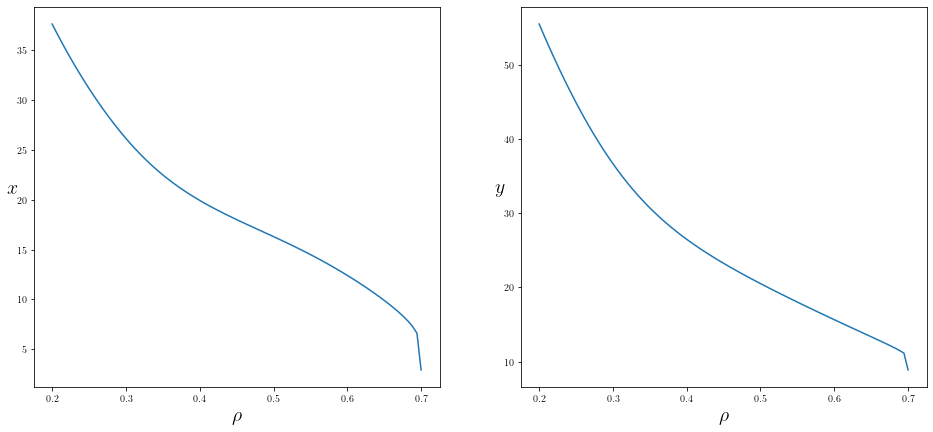

In [26]:
# Plot the FP data in 2d...
plt.figure(figsize=(16,7))
plt.subplot(1,2,1)
plt.plot(FP1_1.T[0],FP1_1.T[2])
plt.xlabel(r'$\rho$',fontsize=20)
plt.ylabel(r'$x$',fontsize=20,rotation=0)
plt.subplot(1,2,2)
plt.plot(FP1_1.T[0],FP1_1.T[3])
plt.xlabel(r'$\rho$',fontsize=20)
plt.ylabel(r'$y$',fontsize=20,rotation=0)
plt.show()

### FP for FP2

In [27]:
# rho_max=0.745
# rho_min=0.73
# rho_steps=5
# rhospace=np.linspace(rho_min,rho_max,rho_steps)
# R2_1=np.empty([rho_steps,N]) 
# FP2_1=np.empty([rho_steps,4])
# # start from random vec leading to (8.011575394768629,11.948578613390712)
# xpr1_2, xpr2_2, rho_2, FP2_1, R2_1 = inspect_from_random_IC_for_multiple_rho_KEEP_GOING(
#                                      -rand_vec3,rhospace,Minit,xcen,dt,t_time,
#                                      ListenEndTime,TrainEndTime,Win,N,dd1,omega1,
#                                      dd2,omega2,gama,sigma,alpha,beta,xy_1,
#                                      PredictEndTime,Xcen1,FP_err_lim,R2_1,
#                                      FP2_1)

In [28]:
# print(f'stops tracking at {rho_2}')
# plt.plot(xpr1_2, xpr2_2)

In [29]:
# save the FP data for the 3d plot
#savedata('FP2_1',FP2_1[0:98,:])
FP2_1 = loaddata('FP2_1')
# print(FP2_1)

#plt.plot(xpr1_2,xpr2_2)
# save the limit cycle plot for 3d...
#z_values = np.linspace(0.74, 0.779, 50)
#LC2datax = xpr1_2[0:10000]; LC2datay = xpr2_2[0:10000]
#savedata('FP2_LC1x',LC2datax); savedata('FP2_LC1y',LC2datay)
#LC2datax = loaddata('FP2_LC1x'); LC2datay = loaddata('FP2_LC1y')

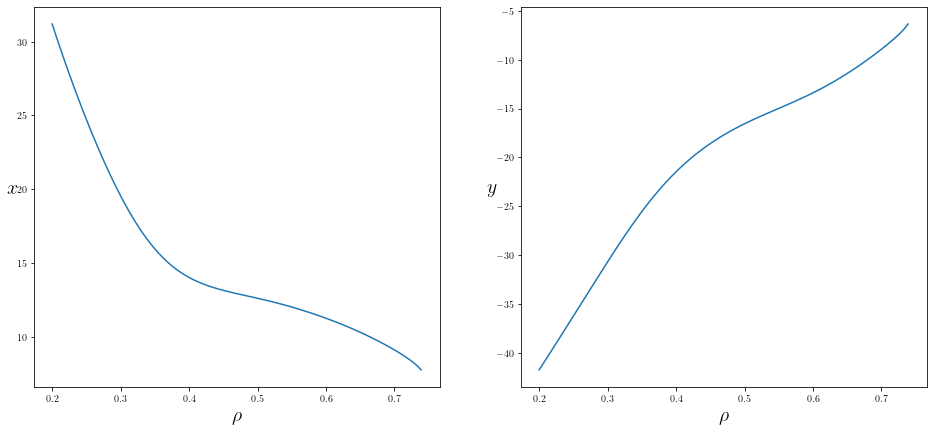

In [30]:
# Plot the FP data in 2d...
plt.figure(figsize=(16,7))
plt.subplot(1,2,1)
plt.plot(FP2_1.T[0],FP2_1.T[2])
plt.xlabel(r'$\rho$',fontsize=20)
plt.ylabel(r'$x$',fontsize=20,rotation=0)
plt.subplot(1,2,2)
plt.plot(FP2_1.T[0],FP2_1.T[3])
plt.xlabel(r'$\rho$',fontsize=20)
plt.ylabel(r'$y$',fontsize=20,rotation=0)
plt.show()

### Get circle plots...

In [31]:
# set up the limit cycle and circle plots for 3d...
z_valuesCA = np.linspace(0.85, 2.09, 50)
z_valuesCB = np.linspace(2.09, 2.49, 50)
z_valuesCB2 = np.linspace(.77, .85, 20)
#CAdatax = x1C2_MF; CAdatay = x2C1_MF
#savedata('FP1_CA1x',CAdatax); savedata('FP1_CA1y',CAdatay)
CAdatax = loaddata('FP1_CA1x'); CAdatay = loaddata('FP1_CA1y')

#CBdatax = x1C2_MF; CBdatay = x2C2_MF
#savedata('FP1_CB1x',CBdatax); savedata('FP1_CB1y',CBdatay)
CBdatax = loaddata('FP1_CB1x'); CBdatay = loaddata('FP1_CB1y')
CB2datax = loaddata('FP1_CB1x'); CB2datay = loaddata('FP1_CB1y')

#multistability regions...
z_valuesMS = np.linspace(1.29, 2.09, 50)
z_valuesMS2 = np.linspace(0.81, 0.85, 10)
# z_valuesMS3 = np.linspace(2.40, 2.46, 50)
r = 1.0  # radius
theta = np.linspace(0, 2*np.pi, 100)  # angles
xMS = r * np.cos(theta)  # x coordinates
yMS = r * np.sin(theta)  # y coordinates

### Sanity check at rho 1.6.. YES MF

In [32]:
# rho_max=1.6
# rho_min=rho_max
# rho_steps=1
# rhospace=np.linspace(rho_min,rho_max,rho_steps)

# x1C1_MF,x2C1_MF,x1C2_MF,x2C2_MF,xy_1,Wout_alpha,M = trainRC_part1(rhospace,Minit,xcen,alpha,dt,
#               t_time,ListenEndTime,TrainEndTime,PredictEndTime,Win,largest_evalue,N,dd1,omega1,dd2,omega2,gama,sigma,beta,
#               FP_err_lim,FP_sample_start,FP_sample_end,LC_err_tol,rounding_no,sample_start,sample_end,stepback,Xcen1,ycen,
#               iter_no,Xcen2)

# plt.plot(x1C1_MF,x2C1_MF)
# plt.plot(x1C1_MF[-10],x2C1_MF[-10],'go')
# plt.plot(x1C1_MF[-1],x2C1_MF[-1],'ro')
# plt.plot(x1C2_MF,x2C2_MF)
# plt.plot(x1C2_MF[-10],x2C2_MF[-10],'go')
# plt.plot(x1C2_MF[-1],x2C2_MF[-1],'ro')

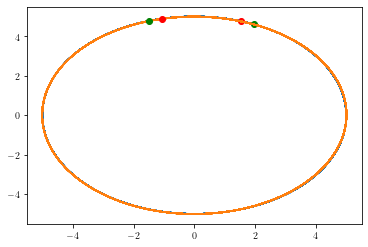

In [33]:
# save this for later...
# savedata('YesMFrho16_FFRC_x1C1_MF',x1C1_MF)
# savedata('YesMFrho16_FFRC_x2C1_MF',x2C1_MF)
# savedata('YesMFrho16_FFRC_x1C2_MF',x1C2_MF)
# savedata('YesMFrho16_FFRC_x2C2_MF',x2C2_MF)

x1C1_MF = loaddata('YesMFrho16_FFRC_x1C1_MF')
x2C1_MF = loaddata('YesMFrho16_FFRC_x2C1_MF')
x1C2_MF = loaddata('YesMFrho16_FFRC_x1C2_MF')
x2C2_MF = loaddata('YesMFrho16_FFRC_x2C2_MF')

plt.plot(x1C1_MF,x2C1_MF)
plt.plot(x1C1_MF[-10],x2C1_MF[-10],'go')
plt.plot(x1C1_MF[-1],x2C1_MF[-1],'ro')
plt.plot(x1C2_MF,x2C2_MF)
plt.plot(x1C2_MF[-10],x2C2_MF[-10],'go')
plt.plot(x1C2_MF[-1],x2C2_MF[-1],'ro')

## 3D plot simple...

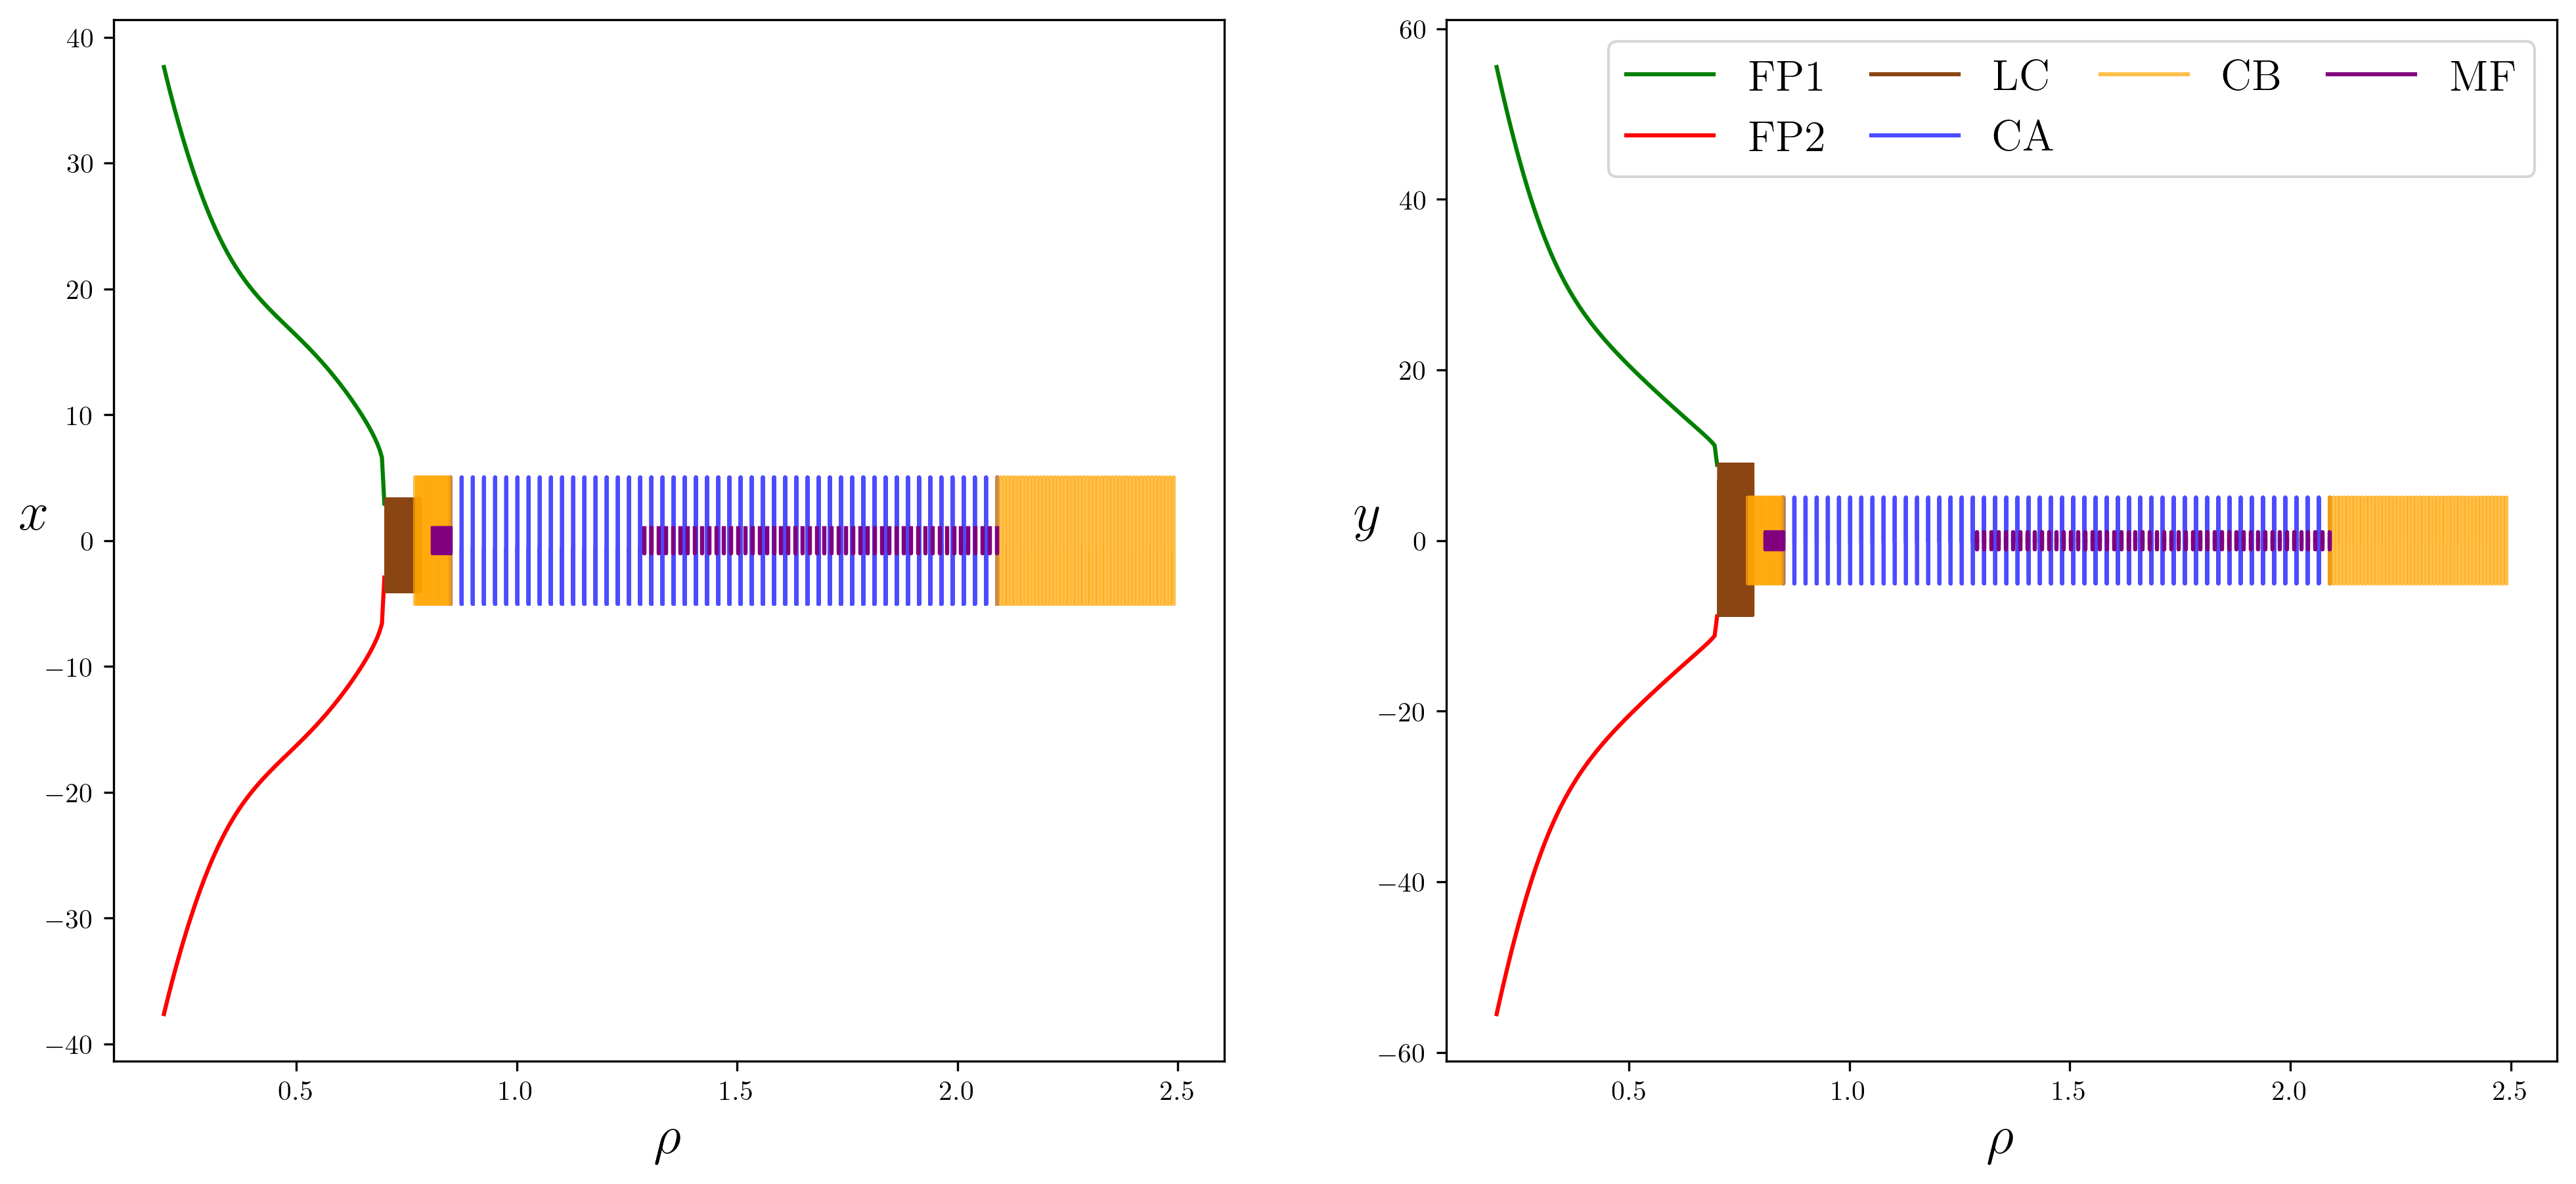

In [34]:
# 2D first...
plt.figure(figsize=(16,7),dpi=300)
plt.subplot(1,2,1)
plt.plot(FP1_1.T[0],FP1_1.T[2],'g')
plt.plot(FP1_1.T[0],-FP1_1.T[2],'r')
for z in z_values:
    plt.plot(z*np.ones_like(LCdatax),LCdatax, 'saddlebrown')
for z in z_valuesCA:
    plt.plot(z*np.ones_like(CAdatax),CAdatax, 'blue', alpha=0.7)
for z in z_valuesCB:
    plt.plot(z*np.ones_like(CBdatax),CBdatax, 'orange', alpha=0.7)
for z in z_valuesCB2:
    plt.plot(z*np.ones_like(CB2datax),CB2datax, 'orange', alpha=0.7)
for z in z_valuesMS:
    plt.plot(z*np.ones_like(xMS),xMS, 'purple', alpha=1)
for z in z_valuesMS2:
    plt.plot(z*np.ones_like(xMS),xMS, 'purple', alpha=1)

plt.xlabel(r'$\rho$',fontsize=20)
plt.ylabel(r'$x$',fontsize=20,rotation=0)
plt.subplot(1,2,2)
plt.plot(FP1_1.T[0],FP1_1.T[3],'g', label=r'FP1')
plt.plot(FP1_1.T[0],-FP1_1.T[3],'r', label=r'FP2')
for z in enumerate(z_values):
    if(z[0]==0):
        plt.plot(z[1]*np.ones_like(LCdatay),LCdatay, 'saddlebrown', label='LC')        
    plt.plot(z[1]*np.ones_like(LCdatay),LCdatay, 'saddlebrown')
for z in enumerate(z_valuesCA):
    if(z[0]==0):
        plt.plot(z[1]*np.ones_like(CAdatay),CAdatay, 'blue', alpha=0.7,label='CA')
    plt.plot(z[1]*np.ones_like(CAdatay),CAdatay, 'blue', alpha=0.7)
for z in enumerate(z_valuesCB):
    if(z[0]==0):
        plt.plot(z[1]*np.ones_like(CBdatay),CBdatay, 'orange', alpha=0.7,label='CB')
    plt.plot(z[1]*np.ones_like(CBdatay),CBdatay, 'orange', alpha=0.7)
for z in enumerate(z_valuesCB2):
    plt.plot(z[1]*np.ones_like(CB2datay),CB2datay, 'orange', alpha=0.7)
for z in enumerate(z_valuesMS):
    if(z[0]==0):
        plt.plot(z[1]*np.ones_like(yMS),yMS, 'purple', alpha=1,label='MF')
    plt.plot(z[1]*np.ones_like(yMS),yMS, 'purple', alpha=1)
for z in z_valuesMS2:
    plt.plot(z*np.ones_like(yMS),yMS, 'purple', alpha=1)
plt.xlabel(r'$\rho$',fontsize=20)
plt.ylabel(r'$y$',fontsize=20,rotation=0)
plt.legend(loc='upper right',ncol=4,fontsize=16,handlelength=2,columnspacing=1)
plt.show()

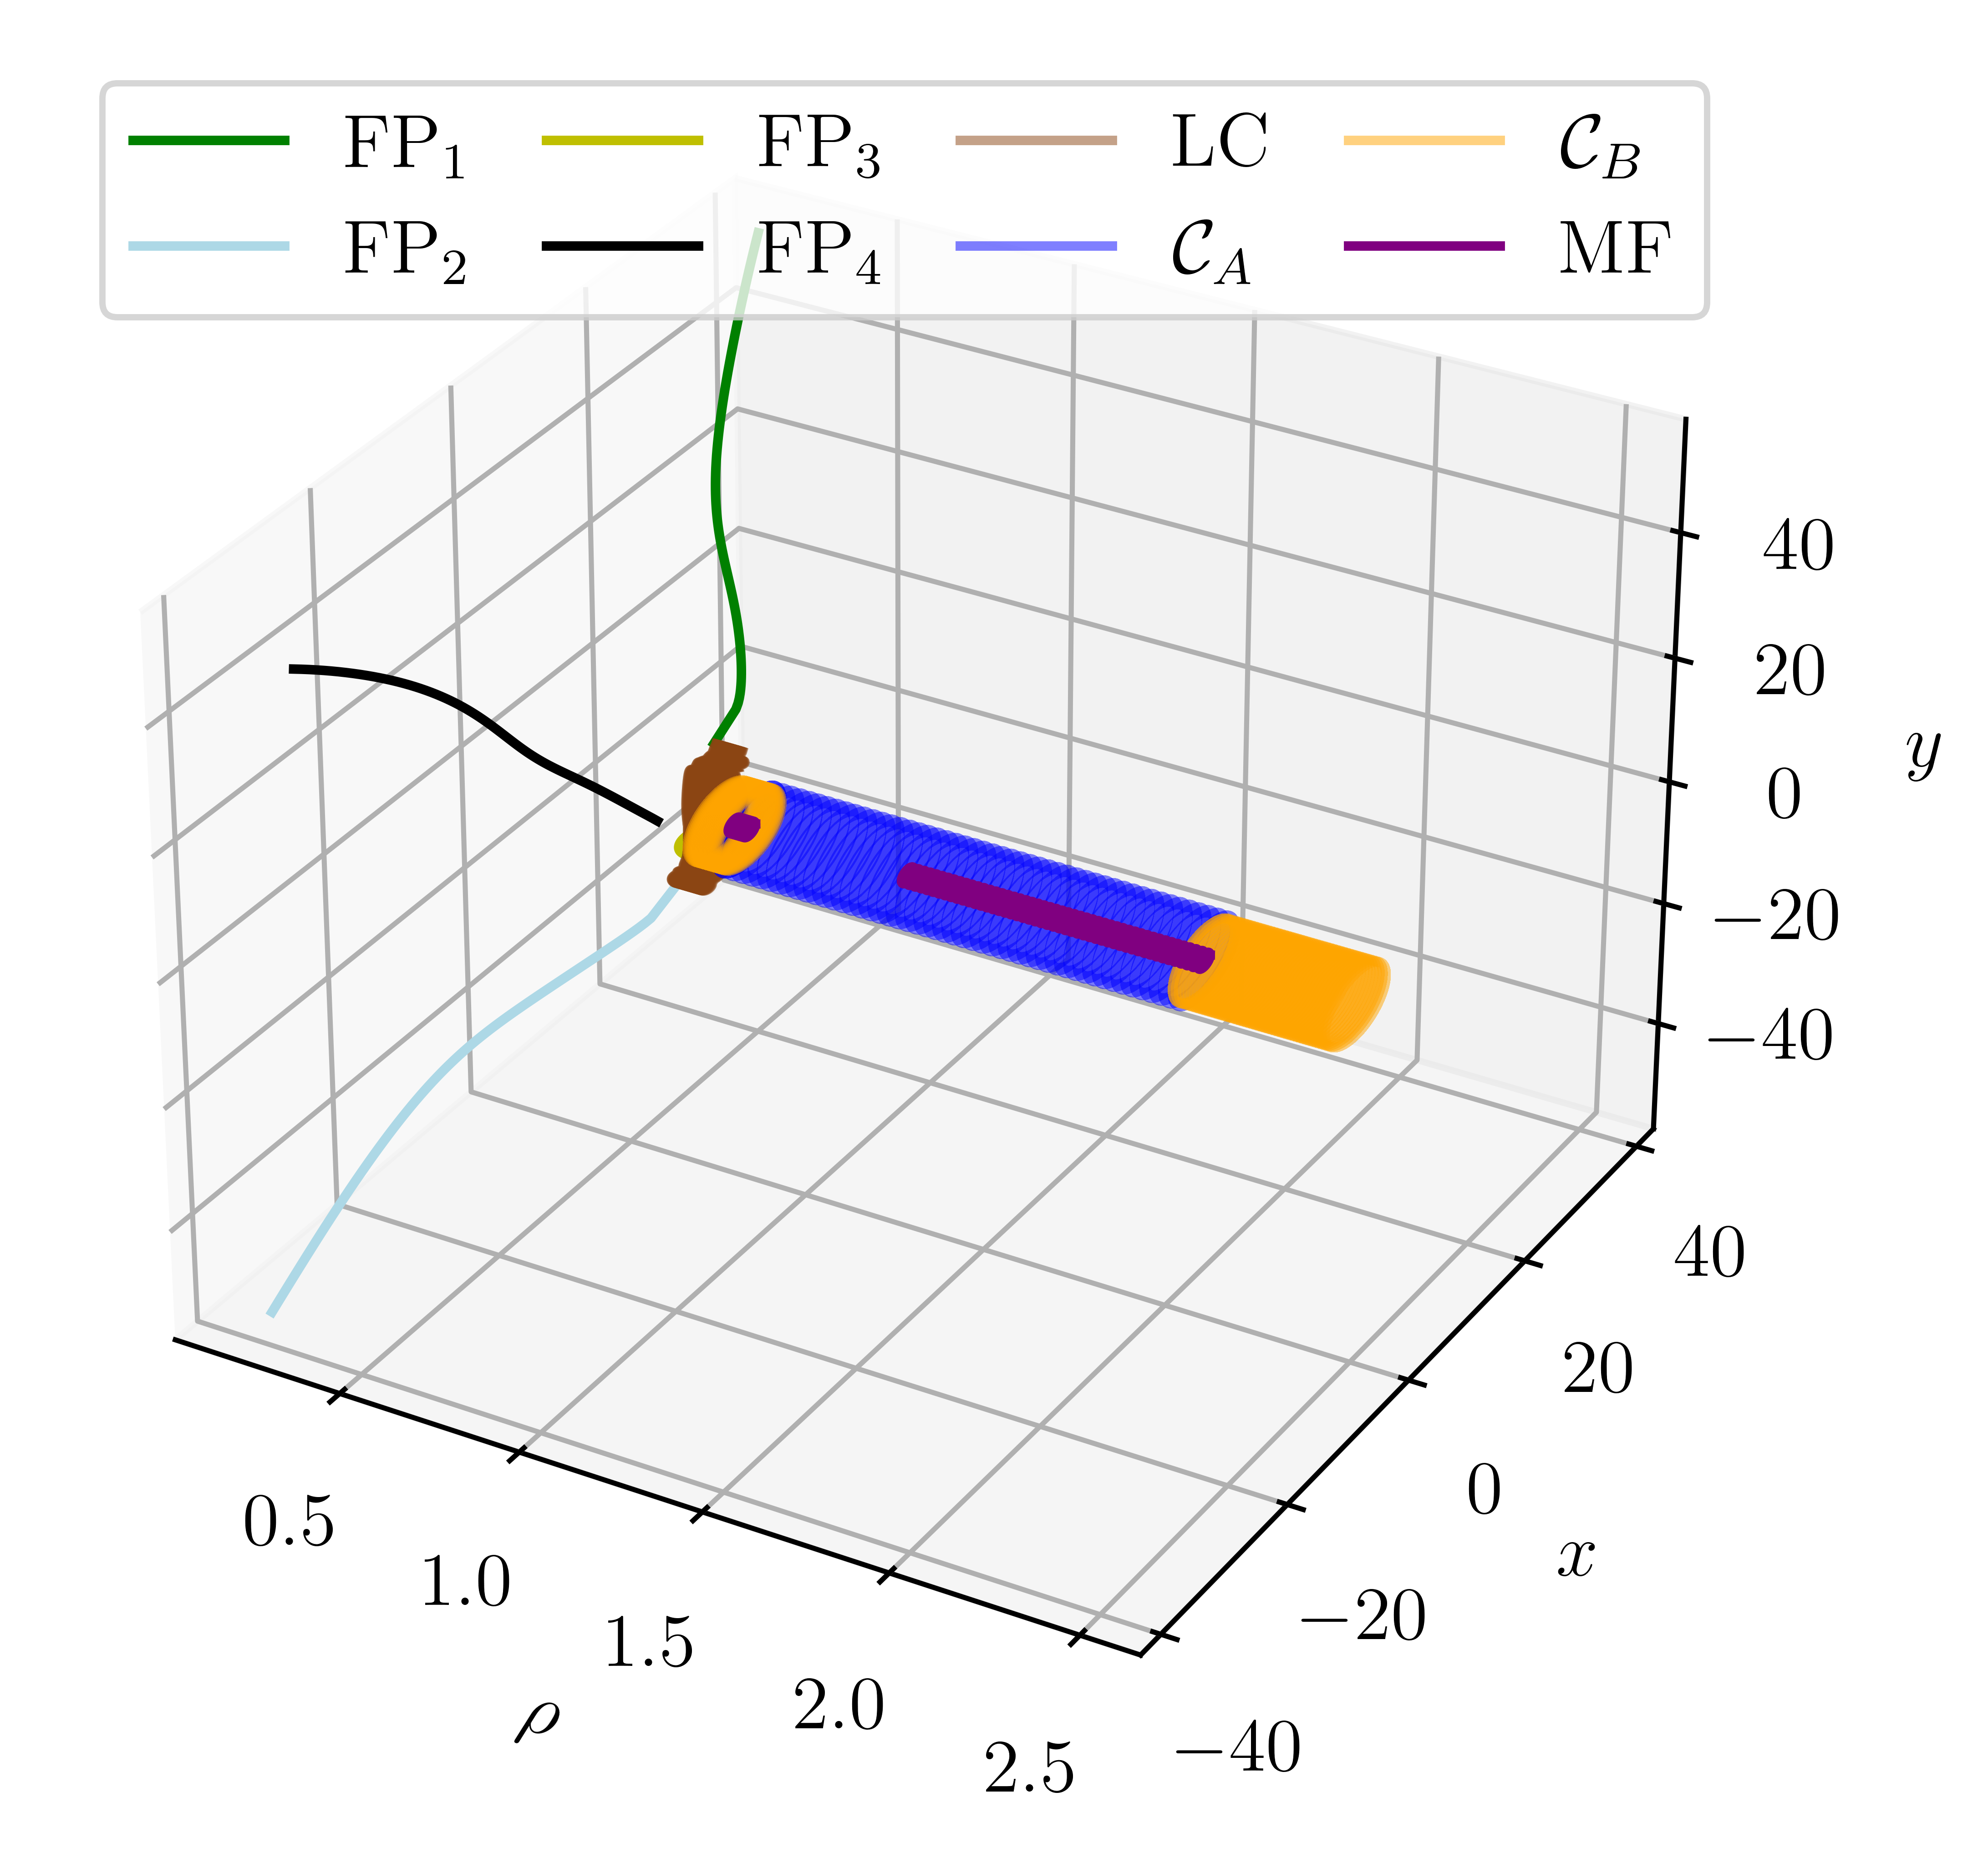

In [35]:
# now 3D...

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D axes object
fig = plt.figure(figsize=(11,5),dpi=1000)
ax = fig.add_subplot(111, projection='3d')

# plot in 3d
plt.plot(FP1_1.T[0],FP1_1.T[2],FP1_1.T[3],'g', label=r'FP${}_1$')
plt.plot(FP1_1.T[0],-FP1_1.T[2],-FP1_1.T[3],'lightblue', label=r'FP${}_2$')
plt.plot(FP2_1.T[0],FP2_1.T[2],FP2_1.T[3],'y', label=r'FP${}_3$')
plt.plot(FP2_1.T[0],-FP2_1.T[2],-FP2_1.T[3],'black', label=r'FP${}_4$')

for z in enumerate(z_values):
    if(z[0]==0):
        plt.plot(z[1]*np.ones_like(LCdatax),LCdatax, LCdatay,alpha=0.5,color='saddlebrown',label='LC')        
    plt.plot(z[1]*np.ones_like(LCdatax),LCdatax,LCdatay, alpha=0.5,color='saddlebrown')
for z in enumerate(z_valuesCA):
    if(z[0]==0):
        plt.plot(z[1]*np.ones_like(CAdatax),CAdatax,CAdatay, 'blue', alpha=0.5,label=r'$\mathcal{C}_{A}$')
    plt.plot(z[1]*np.ones_like(CAdatax),CAdatax, CAdatay,'blue', alpha=0.5)
for z in enumerate(z_valuesCB):
    if(z[0]==0):
        plt.plot(z[1]*np.ones_like(CBdatax),CBdatax,CBdatay, 'orange', alpha=0.5,label=r'$\mathcal{C}_{B}$')
    plt.plot(z[1]*np.ones_like(CBdatax),CBdatax, CBdatay,'orange', alpha=0.5)
for z in enumerate(z_valuesCB2):
    plt.plot(z[1]*np.ones_like(CBdatax),CBdatax, CBdatay,'orange', alpha=0.5)
for z in enumerate(z_valuesMS):
    if(z[0]==0):
        plt.plot(z[1]*np.ones_like(xMS),xMS,yMS, 'purple', alpha=1,label='MF')
    plt.plot(z[1]*np.ones_like(xMS),xMS, yMS,'purple', alpha=1)
for z in enumerate(z_valuesMS2):
    plt.plot(z[1]*np.ones_like(xMS),xMS,yMS, 'purple', alpha=1)

# Set labels for the axes
ax.set_xlabel(r'$\rho$',fontsize=12)
ax.set_ylabel(r'$x$',fontsize=12)
ax.set_zlabel(r'$y$',fontsize=12)

# Adjust font size of axis ticks
ax.tick_params(axis='both', which='major', labelsize=12)

plt.legend(loc='upper center',ncol=4,fontsize=12,handlelength=2,columnspacing=1)

# Show the plot
plt.show()